In [46]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import warnings
warnings.filterwarnings("ignore")

In [2]:
members = pd.read_csv('data/members.csv')
song_extra_info = pd.read_csv('data/song_extra_info.csv')
songs = pd.read_csv('data/songs.csv')
train = pd.read_csv('data/train.csv')

train.head()

,msno,song_id,source_system_tab,source_screen_name,source_type,target
0,FGtllVqz18RPiwJj/edr2gV78zirAiY/9SmYvia+kCg=,BBzumQNXUHKdEBOB7mAJuzok+IJA1c2Ryg/yzTF6tik=,explore,Explore,online-playlist,1
1,Xumu+NIjS6QYVxDS4/t3SawvJ7viT9hPKXmf0RtLNx8=,bhp/MpSNoqoxOIB+/l8WPqu6jldth4DIpCm3ayXnJqM=,my library,Local playlist more,local-playlist,1
2,Xumu+NIjS6QYVxDS4/t3SawvJ7viT9hPKXmf0RtLNx8=,JNWfrrC7zNN7BdMpsISKa4Mw+xVJYNnxXh3/Epw7QgY=,my library,Local playlist more,local-playlist,1
3,Xumu+NIjS6QYVxDS4/t3SawvJ7viT9hPKXmf0RtLNx8=,2A87tzfnJTSWqD7gIZHisolhe4DMdzkbd6LzO1KHjNs=,my library,Local playlist more,local-playlist,1
4,FGtllVqz18RPiwJj/edr2gV78zirAiY/9SmYvia+kCg=,3qm6XTZ6MOCU11x8FIVbAGH5l5uMkT3/ZalWG1oo2Gc=,explore,Explore,online-playlist,1


In [3]:
train.iloc[:, 2:].describe(include=['O'])

,source_system_tab,source_screen_name,source_type
count,7352569,6962614,7355879
unique,8,20,12
top,my library,Local playlist more,local-library
freq,3684730,3228202,2261399


In [4]:
for col in train.columns[2:]:
    print(train[col].unique())

['explore' 'my library' 'search' 'discover' nan 'radio' 'listen with'
 'notification' 'settings']
['Explore' 'Local playlist more' nan 'My library' 'Online playlist more'
 'Album more' 'Discover Feature' 'Unknown' 'Discover Chart' 'Radio'
 'Artist more' 'Search' 'Others profile more' 'Search Trends'
 'Discover Genre' 'My library_Search' 'Search Home' 'Discover New'
 'Self profile more' 'Concert' 'Payment']
['online-playlist' 'local-playlist' 'local-library' 'top-hits-for-artist'
 'album' nan 'song-based-playlist' 'radio' 'song' 'listen-with' 'artist'
 'topic-article-playlist' 'my-daily-playlist']
[1 0]


Сразу в трейне видим обилие категориальных переменных с большим количеством категорий. Таргет имеет два значения. Хотя в задаче описана рекомендательная система, в трейне у нас есть только данные о том, что пользователь снова запустил песню (предполагается, что она понравилась), поэтому будем решать задачу бинарной классификации и ранжировать в проде по вероятности принадлежности к целевому классу.

Заметим тут же, что данные время-зависимые, вероятно, это стоит учесть.

Присутствующие пропуски, скорее всего будет разумно заменить на отдельную категорию. Либо на подходящую существующую, если данные будут похожи, например Nan в source_screen_name заменить на значение 'Unknown'. Пока заменю отдельной категорией - 'NONE'.

In [5]:
train.isna().sum()

msno                       0
song_id                    0
source_system_tab      24849
source_screen_name    414804
source_type            21539
target                     0
dtype: int64

In [6]:
train.fillna('NONE', inplace=True)

train.isna().sum().sum()

0

In [7]:
members.head()

,msno,city,bd,gender,registered_via,registration_init_time,expiration_date
0,XQxgAYj3klVKjR3oxPPXYYFp4soD4TuBghkhMTD4oTw=,1,0,NaN,7,20110820,20170920
1,UizsfmJb9mV54qE9hCYyU07Va97c0lCRLEQX3ae+ztM=,1,0,NaN,7,20150628,20170622
2,D8nEhsIOBSoE6VthTaqDX8U6lqjJ7dLdr72mOyLya2A=,1,0,NaN,4,20160411,20170712
3,mCuD+tZ1hERA/o5GPqk38e041J8ZsBaLcu7nGoIIvhI=,1,0,NaN,9,20150906,20150907
4,q4HRBfVSssAFS9iRfxWrohxuk9kCYMKjHOEagUMV6rQ=,1,0,NaN,4,20170126,20170613


In [8]:
members.city.unique()

array([ 1, 13, 12, 15,  5,  6,  4, 11, 18, 22, 14,  8, 20,  3, 17, 10, 16,
        9, 21,  7, 19], dtype=int64)

In [9]:
members.bd.unique()

array([   0,   43,   28,   33,   20,   30,   29,   26,   25,   21,   22,
         16,   23,   37,   18,   19,   51,   24,   17,   45,   36,   57,
         27,   34,   32,   15,   48,   50,   54,   47,   35,   46,   31,
         14,   41,   59,    2,   40,   38,   55,   39,   73,   49,   44,
        103,   52,   70,   42,   65,   56,  101,   58,   53,   64,   63,
         76,   66,   97,    3,   72,   67,   62,   61,  105,   60,   13,
         90,   12,   68,  131,   74,   89,  931,  -38,  144,   85,  112,
         96,   11,  102,   83, 1051,   87,    7,   95,  -43,  111,   93,
          5,   78, 1030,  106,  107,   82,   10], dtype=int64)

In [10]:
members.bd.describe()

count    34403.000000
mean        12.280935
std         18.170251
min        -43.000000
25%          0.000000
50%          0.000000
75%         25.000000
max       1051.000000
Name: bd, dtype: float64

In [11]:
members.registered_via.unique()

array([ 7,  4,  9,  3, 13, 16], dtype=int64)

Таблица members очень странная. Запомним, что столбец город, вероятно, категориальный. Как и registered_via. Значения в графе bd (в описании сказано, что это возраст) в принципе странные. Похоже, пользователь мог заполнять эту графу любым числом. Вероятно, целесообразно заменить, на категории: 0 - не указал, дети, подростки, молодежь, взрослые, запредельные значения выделить в отдельную категорию "пошутивших")

C:\Users\User\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


<Axes: xlabel='bd', ylabel='Count'>

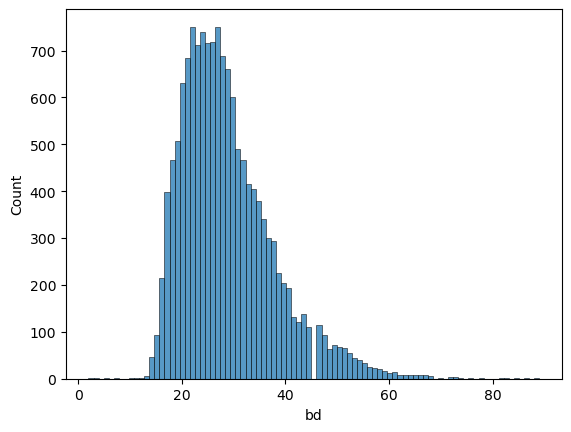

In [12]:
members.bd.fillna(0, inplace=True)
sns.histplot(members.bd[(members.bd > 0) & (members.bd < 90)])

Чтобы выделить отдельные возрастные группы, нужно проводить отдельное исследование или ориентироваться на что-то общепринятое. В качестве промежуточного решения, чтобы не потерять информацию о возрасте решил все странные значения возраста заменить на среднее, и добавить бинарную категорию, "указан ли возраст".

In [13]:
members['indicated_age'] = members['bd'].apply(lambda x: 1 if 10 < x < 70 else 0)
mean_age = members.bd[(members.bd > 10) & (members.bd < 70)].mean()
members.bd = members.bd.apply(lambda x: x if 10 < x < 70 else mean_age)

members.head()

,msno,city,bd,gender,registered_via,registration_init_time,expiration_date,indicated_age
0,XQxgAYj3klVKjR3oxPPXYYFp4soD4TuBghkhMTD4oTw=,1,28.824247,NaN,7,20110820,20170920,0
1,UizsfmJb9mV54qE9hCYyU07Va97c0lCRLEQX3ae+ztM=,1,28.824247,NaN,7,20150628,20170622,0
2,D8nEhsIOBSoE6VthTaqDX8U6lqjJ7dLdr72mOyLya2A=,1,28.824247,NaN,4,20160411,20170712,0
3,mCuD+tZ1hERA/o5GPqk38e041J8ZsBaLcu7nGoIIvhI=,1,28.824247,NaN,9,20150906,20150907,0
4,q4HRBfVSssAFS9iRfxWrohxuk9kCYMKjHOEagUMV6rQ=,1,28.824247,NaN,4,20170126,20170613,0


In [14]:
members.isna().sum()

msno                          0
city                          0
bd                            0
gender                    19902
registered_via                0
registration_init_time        0
expiration_date               0
indicated_age                 0
dtype: int64

In [15]:
members.fillna('NONE', inplace=True)
members.isna().sum().sum()

0

In [16]:
song_extra_info.head()

,song_id,name,isrc
0,LP7pLJoJFBvyuUwvu+oLzjT+bI+UeBPURCecJsX1jjs=,我們,TWUM71200043
1,ClazTFnk6r0Bnuie44bocdNMM3rdlrq0bCGAsGUWcHE=,Let Me Love You,QMZSY1600015
2,u2ja/bZE3zhCGxvbbOB3zOoUjx27u40cf5g09UXMoKQ=,原諒我,TWA530887303
3,92Fqsy0+p6+RHe2EoLKjHahORHR1Kq1TBJoClW9v+Ts=,Classic,USSM11301446
4,0QFmz/+rJy1Q56C1DuYqT9hKKqi5TUqx0sN0IwvoHrw=,愛投羅網,TWA471306001


Здесь важно отметить, что из isrc можно вытащить дополнительные данные. Хотя, в описании, дополнительно указали, что этот код может содержать ошибки. Попробовать, все равно стоит. Самое полезное - первые два знака - страна, и 6-7 знак - год.

In [17]:
song_extra_info['country'] = song_extra_info['isrc'].astype(str).apply(lambda x: x[:2])
song_extra_info['year'] = song_extra_info['isrc'].astype(str).apply(lambda x: x[5:7])
song_extra_info['year']

0          12
1          16
2          08
3          13
4          13
           ..
2295966    17
2295967    15
2295968    15
2295969    93
2295970    15
Name: year, Length: 2295971, dtype: object

In [18]:
song_extra_info['country'].nunique()

201

In [19]:
def to_year(x):
    if x == '':
        return None
    else:
        a = int(x)
    return int('19' + x) if a > 18 else int('20' + x)
        

song_extra_info['year'] = song_extra_info['year'].apply(to_year)
song_extra_info['year'].fillna(song_extra_info['year'].mean(), inplace=True)

song_extra_info.head()

,song_id,name,isrc,country,year
0,LP7pLJoJFBvyuUwvu+oLzjT+bI+UeBPURCecJsX1jjs=,我們,TWUM71200043,TW,2012.0
1,ClazTFnk6r0Bnuie44bocdNMM3rdlrq0bCGAsGUWcHE=,Let Me Love You,QMZSY1600015,QM,2016.0
2,u2ja/bZE3zhCGxvbbOB3zOoUjx27u40cf5g09UXMoKQ=,原諒我,TWA530887303,TW,2008.0
3,92Fqsy0+p6+RHe2EoLKjHahORHR1Kq1TBJoClW9v+Ts=,Classic,USSM11301446,US,2013.0
4,0QFmz/+rJy1Q56C1DuYqT9hKKqi5TUqx0sN0IwvoHrw=,愛投羅網,TWA471306001,TW,2013.0


In [20]:
song_extra_info['year'] = pd.to_datetime(song_extra_info['year'], format='%Y').dt.year
song_extra_info = song_extra_info.drop(['isrc'], axis=1)
song_extra_info.head()

,song_id,name,country,year
0,LP7pLJoJFBvyuUwvu+oLzjT+bI+UeBPURCecJsX1jjs=,我們,TW,2012
1,ClazTFnk6r0Bnuie44bocdNMM3rdlrq0bCGAsGUWcHE=,Let Me Love You,QM,2016
2,u2ja/bZE3zhCGxvbbOB3zOoUjx27u40cf5g09UXMoKQ=,原諒我,TW,2008
3,92Fqsy0+p6+RHe2EoLKjHahORHR1Kq1TBJoClW9v+Ts=,Classic,US,2013
4,0QFmz/+rJy1Q56C1DuYqT9hKKqi5TUqx0sN0IwvoHrw=,愛投羅網,TW,2013


In [21]:
song_extra_info.isna().sum()

song_id    0
name       3
country    0
year       0
dtype: int64

С отсутствующим осталось 3 объекта. Пока оставим, потом можно будет просто удалить.

In [22]:
songs.head()

,song_id,song_length,genre_ids,artist_name,composer,lyricist,language
0,CXoTN1eb7AI+DntdU1vbcwGRV4SCIDxZu+YD8JP8r4E=,247640,465,張信哲 (Jeff Chang),董貞,何啟弘,3.0
1,o0kFgae9QtnYgRkVPqLJwa05zIhRlUjfF7O1tDw0ZDU=,197328,444,BLACKPINK,TEDDY| FUTURE BOUNCE| Bekuh BOOM,TEDDY,31.0
2,DwVvVurfpuz+XPuFvucclVQEyPqcpUkHR0ne1RQzPs0=,231781,465,SUPER JUNIOR,NaN,NaN,31.0
3,dKMBWoZyScdxSkihKG+Vf47nc18N9q4m58+b4e7dSSE=,273554,465,S.H.E,湯小康,徐世珍,3.0
4,W3bqWd3T+VeHFzHAUfARgW9AvVRaF4N5Yzm4Mr6Eo/o=,140329,726,貴族精選,Traditional,Traditional,52.0


In [23]:
songs.genre_ids.unique()

array(['465', '444', '726', ..., '786|958|2022', '1259|2107', '1138|2022'],
      dtype=object)

In [24]:
songs.language.nunique()

10

In [25]:
songs.genre_ids[songs.genre_ids.apply(str).apply(len) <= 4].nunique()

172

In [26]:
songs.artist_name.unique()

array(['張信哲 (Jeff Chang)', 'BLACKPINK', 'SUPER JUNIOR', ...,
       'Charley Brownn', 'Avaleya and The GlitterHawks',
       'Renato pezzella| Renato Pezzella'], dtype=object)

In [27]:
songs.lyricist.unique()

array(['何啟弘', 'TEDDY', nan, ..., 'Otoniel Santos', 'Stepz|Branco',
       'Rodney Clawson| Vicky McGehee| David Lee Murphy'], dtype=object)

Также обилие категориальных переменных. Отдельно стоит учесть, что в графе genre_ids объект может быть отнесен к нескольким жанрам. Пока, кажется, что сочетание жанра лучше оставить как отдельную категорию, так как делать onehot по отдельным жанрам слишком объемно. Всего жанров, похоже, порядка 172. Есть ещё вариант оставить только один жанр, например - первый, или сделать какую-то агрегацию. Пока оставим этот вопрос.

Тоже касается artist_name, composer и lyricist.

В каждой из этих колонок оставлю только первое значение, из предположения, что оно является основным не только в содержании описания объекта, но и влияющим на пользователя. Безусловно, часть информации теряется, это будем помнить.

In [28]:
def take_first(x):
    if (type(x) == str) and ('|' in x):
        return x.split('|')[0]
    return x

songs.genre_ids = songs.genre_ids.apply(take_first)
songs.artist_name = songs.artist_name.apply(take_first)
songs.lyricist = songs.lyricist.apply(take_first)
songs.composer = songs.composer.apply(take_first)

songs.isna().sum()

song_id              0
song_length          0
genre_ids        94116
artist_name          0
composer       1071358
lyricist       1945306
language             1
dtype: int64

In [29]:
songs.shape

(2296320, 7)

Надо было сначала проверить пропуски, но нестрашно. Колонку автора слов и композитора стоит удалить, так как большинство и половина соответственно являются пропусками. В жанре заполню отдельным значением. Останется язык, с ним как и с name выше посмотрю что делать после мерджа.

In [30]:
songs = songs.drop(['composer', 'lyricist'], axis=1)
songs.genre_ids.fillna('NONE', inplace=True)
songs.head()

,song_id,song_length,genre_ids,artist_name,language
0,CXoTN1eb7AI+DntdU1vbcwGRV4SCIDxZu+YD8JP8r4E=,247640,465,張信哲 (Jeff Chang),3.0
1,o0kFgae9QtnYgRkVPqLJwa05zIhRlUjfF7O1tDw0ZDU=,197328,444,BLACKPINK,31.0
2,DwVvVurfpuz+XPuFvucclVQEyPqcpUkHR0ne1RQzPs0=,231781,465,SUPER JUNIOR,31.0
3,dKMBWoZyScdxSkihKG+Vf47nc18N9q4m58+b4e7dSSE=,273554,465,S.H.E,3.0
4,W3bqWd3T+VeHFzHAUfARgW9AvVRaF4N5Yzm4Mr6Eo/o=,140329,726,貴族精選,52.0


In [31]:
data = train.merge(members, how='left', on='msno')
data = data.merge(song_extra_info, how='left', on='song_id')
data = data.merge(songs, how='left', on='song_id')

data.head()

,msno,song_id,source_system_tab,source_screen_name,source_type,target,city,bd,gender,registered_via,registration_init_time,expiration_date,indicated_age,name,country,year,song_length,genre_ids,artist_name,language
0,FGtllVqz18RPiwJj/edr2gV78zirAiY/9SmYvia+kCg=,BBzumQNXUHKdEBOB7mAJuzok+IJA1c2Ryg/yzTF6tik=,explore,Explore,online-playlist,1,1,28.824247,NONE,7,20120102,20171005,0,Good Grief,GB,2016.0,206471.0,359,Bastille,52.0
1,Xumu+NIjS6QYVxDS4/t3SawvJ7viT9hPKXmf0RtLNx8=,bhp/MpSNoqoxOIB+/l8WPqu6jldth4DIpCm3ayXnJqM=,my library,Local playlist more,local-playlist,1,13,24.000000,female,9,20110525,20170911,1,Lords of Cardboard,US,1999.0,284584.0,1259,Various Artists,52.0
2,Xumu+NIjS6QYVxDS4/t3SawvJ7viT9hPKXmf0RtLNx8=,JNWfrrC7zNN7BdMpsISKa4Mw+xVJYNnxXh3/Epw7QgY=,my library,Local playlist more,local-playlist,1,13,24.000000,female,9,20110525,20170911,1,Hip Hop Is Dead(Album Version (Edited)),US,2006.0,225396.0,1259,Nas,52.0
3,Xumu+NIjS6QYVxDS4/t3SawvJ7viT9hPKXmf0RtLNx8=,2A87tzfnJTSWqD7gIZHisolhe4DMdzkbd6LzO1KHjNs=,my library,Local playlist more,local-playlist,1,13,24.000000,female,9,20110525,20170911,1,Disco Africa,GB,2010.0,255512.0,1019,Soundway,-1.0
4,FGtllVqz18RPiwJj/edr2gV78zirAiY/9SmYvia+kCg=,3qm6XTZ6MOCU11x8FIVbAGH5l5uMkT3/ZalWG1oo2Gc=,explore,Explore,online-playlist,1,1,28.824247,NONE,7,20120102,20171005,0,Sleep Without You,QM,2016.0,187802.0,1011,Brett Young,52.0


In [32]:
data.isna().sum()

msno                         0
song_id                      0
source_system_tab            0
source_screen_name           0
source_type                  0
target                       0
city                         0
bd                           0
gender                       0
registered_via               0
registration_init_time       0
expiration_date              0
indicated_age                0
name                      1457
country                   1455
year                      1455
song_length                114
genre_ids                  114
artist_name                114
language                   150
dtype: int64

Относительно общего числа данных, данных с None осталось совсем немного. Просто удалю их датасета и можно будет перейти к обзору данных.

In [33]:
data.dropna(inplace=True)
data.head()

,msno,song_id,source_system_tab,source_screen_name,source_type,target,city,bd,gender,registered_via,registration_init_time,expiration_date,indicated_age,name,country,year,song_length,genre_ids,artist_name,language
0,FGtllVqz18RPiwJj/edr2gV78zirAiY/9SmYvia+kCg=,BBzumQNXUHKdEBOB7mAJuzok+IJA1c2Ryg/yzTF6tik=,explore,Explore,online-playlist,1,1,28.824247,NONE,7,20120102,20171005,0,Good Grief,GB,2016.0,206471.0,359,Bastille,52.0
1,Xumu+NIjS6QYVxDS4/t3SawvJ7viT9hPKXmf0RtLNx8=,bhp/MpSNoqoxOIB+/l8WPqu6jldth4DIpCm3ayXnJqM=,my library,Local playlist more,local-playlist,1,13,24.000000,female,9,20110525,20170911,1,Lords of Cardboard,US,1999.0,284584.0,1259,Various Artists,52.0
2,Xumu+NIjS6QYVxDS4/t3SawvJ7viT9hPKXmf0RtLNx8=,JNWfrrC7zNN7BdMpsISKa4Mw+xVJYNnxXh3/Epw7QgY=,my library,Local playlist more,local-playlist,1,13,24.000000,female,9,20110525,20170911,1,Hip Hop Is Dead(Album Version (Edited)),US,2006.0,225396.0,1259,Nas,52.0
3,Xumu+NIjS6QYVxDS4/t3SawvJ7viT9hPKXmf0RtLNx8=,2A87tzfnJTSWqD7gIZHisolhe4DMdzkbd6LzO1KHjNs=,my library,Local playlist more,local-playlist,1,13,24.000000,female,9,20110525,20170911,1,Disco Africa,GB,2010.0,255512.0,1019,Soundway,-1.0
4,FGtllVqz18RPiwJj/edr2gV78zirAiY/9SmYvia+kCg=,3qm6XTZ6MOCU11x8FIVbAGH5l5uMkT3/ZalWG1oo2Gc=,explore,Explore,online-playlist,1,1,28.824247,NONE,7,20120102,20171005,0,Sleep Without You,QM,2016.0,187802.0,1011,Brett Young,52.0


In [34]:
cat = ['source_system_tab',
       'source_screen_name',
       'source_type',
       'city',
       'gender',
       'registered_via',
       'indicated_age',
       'country',
       'genre_ids',
       'artist_name',
       'language']

num = ['bd', 
       'registration_init_time', 
       'expiration_date', 
       'year']

Как и ожидалось, получается довольно много категориальных переменных, поэтому смотрю в сторону катбуста. Он хорошо под капотом их обрабатывает. Надо подумать стоит ли обработать как-то названия песен или дать на откуп катбусту. Возникла идея также добавить переменную "время до истечения срока действия подписки". И здесь я заметил, что формат столбцов не registration_init_time и expiration_date не timestamp. Переведем в дату и посчитаем количество дней до конца подписки. А также, подумал, что может быть полезно посчитать разницу между годом песни и возрастом из предположения, что людям больше нравятся песни их молодости, что также будет отражать, что молодые склонны слушать более свежую музыку.

In [35]:
data.registration_init_time = pd.to_datetime(data.registration_init_time.apply(str), format='%Y%m%d')
data.expiration_date = pd.to_datetime(data.expiration_date.apply(str), format='%Y%m%d')

data['days_left'] = data.expiration_date - data.registration_init_time
data['days_left'] = data['days_left'].dt.days

data['age_diff'] = data['year'] - data['bd']

data.head()

,msno,song_id,source_system_tab,source_screen_name,source_type,target,city,bd,gender,registered_via,...,indicated_age,name,country,year,song_length,genre_ids,artist_name,language,days_left,age_diff
0,FGtllVqz18RPiwJj/edr2gV78zirAiY/9SmYvia+kCg=,BBzumQNXUHKdEBOB7mAJuzok+IJA1c2Ryg/yzTF6tik=,explore,Explore,online-playlist,1,1,28.824247,NONE,7,...,0,Good Grief,GB,2016.0,206471.0,359,Bastille,52.0,2103,1987.175753
1,Xumu+NIjS6QYVxDS4/t3SawvJ7viT9hPKXmf0RtLNx8=,bhp/MpSNoqoxOIB+/l8WPqu6jldth4DIpCm3ayXnJqM=,my library,Local playlist more,local-playlist,1,13,24.000000,female,9,...,1,Lords of Cardboard,US,1999.0,284584.0,1259,Various Artists,52.0,2301,1975.000000
2,Xumu+NIjS6QYVxDS4/t3SawvJ7viT9hPKXmf0RtLNx8=,JNWfrrC7zNN7BdMpsISKa4Mw+xVJYNnxXh3/Epw7QgY=,my library,Local playlist more,local-playlist,1,13,24.000000,female,9,...,1,Hip Hop Is Dead(Album Version (Edited)),US,2006.0,225396.0,1259,Nas,52.0,2301,1982.000000
3,Xumu+NIjS6QYVxDS4/t3SawvJ7viT9hPKXmf0RtLNx8=,2A87tzfnJTSWqD7gIZHisolhe4DMdzkbd6LzO1KHjNs=,my library,Local playlist more,local-playlist,1,13,24.000000,female,9,...,1,Disco Africa,GB,2010.0,255512.0,1019,Soundway,-1.0,2301,1986.000000
4,FGtllVqz18RPiwJj/edr2gV78zirAiY/9SmYvia+kCg=,3qm6XTZ6MOCU11x8FIVbAGH5l5uMkT3/ZalWG1oo2Gc=,explore,Explore,online-playlist,1,1,28.824247,NONE,7,...,0,Sleep Without You,QM,2016.0,187802.0,1011,Brett Young,52.0,2103,1987.175753


In [36]:
num.extend(['days_left', 'age_diff'])

Перейдем к обзору данных. Посмотрим на то как представлены категориальные и численные переменные при разном целевом значении.

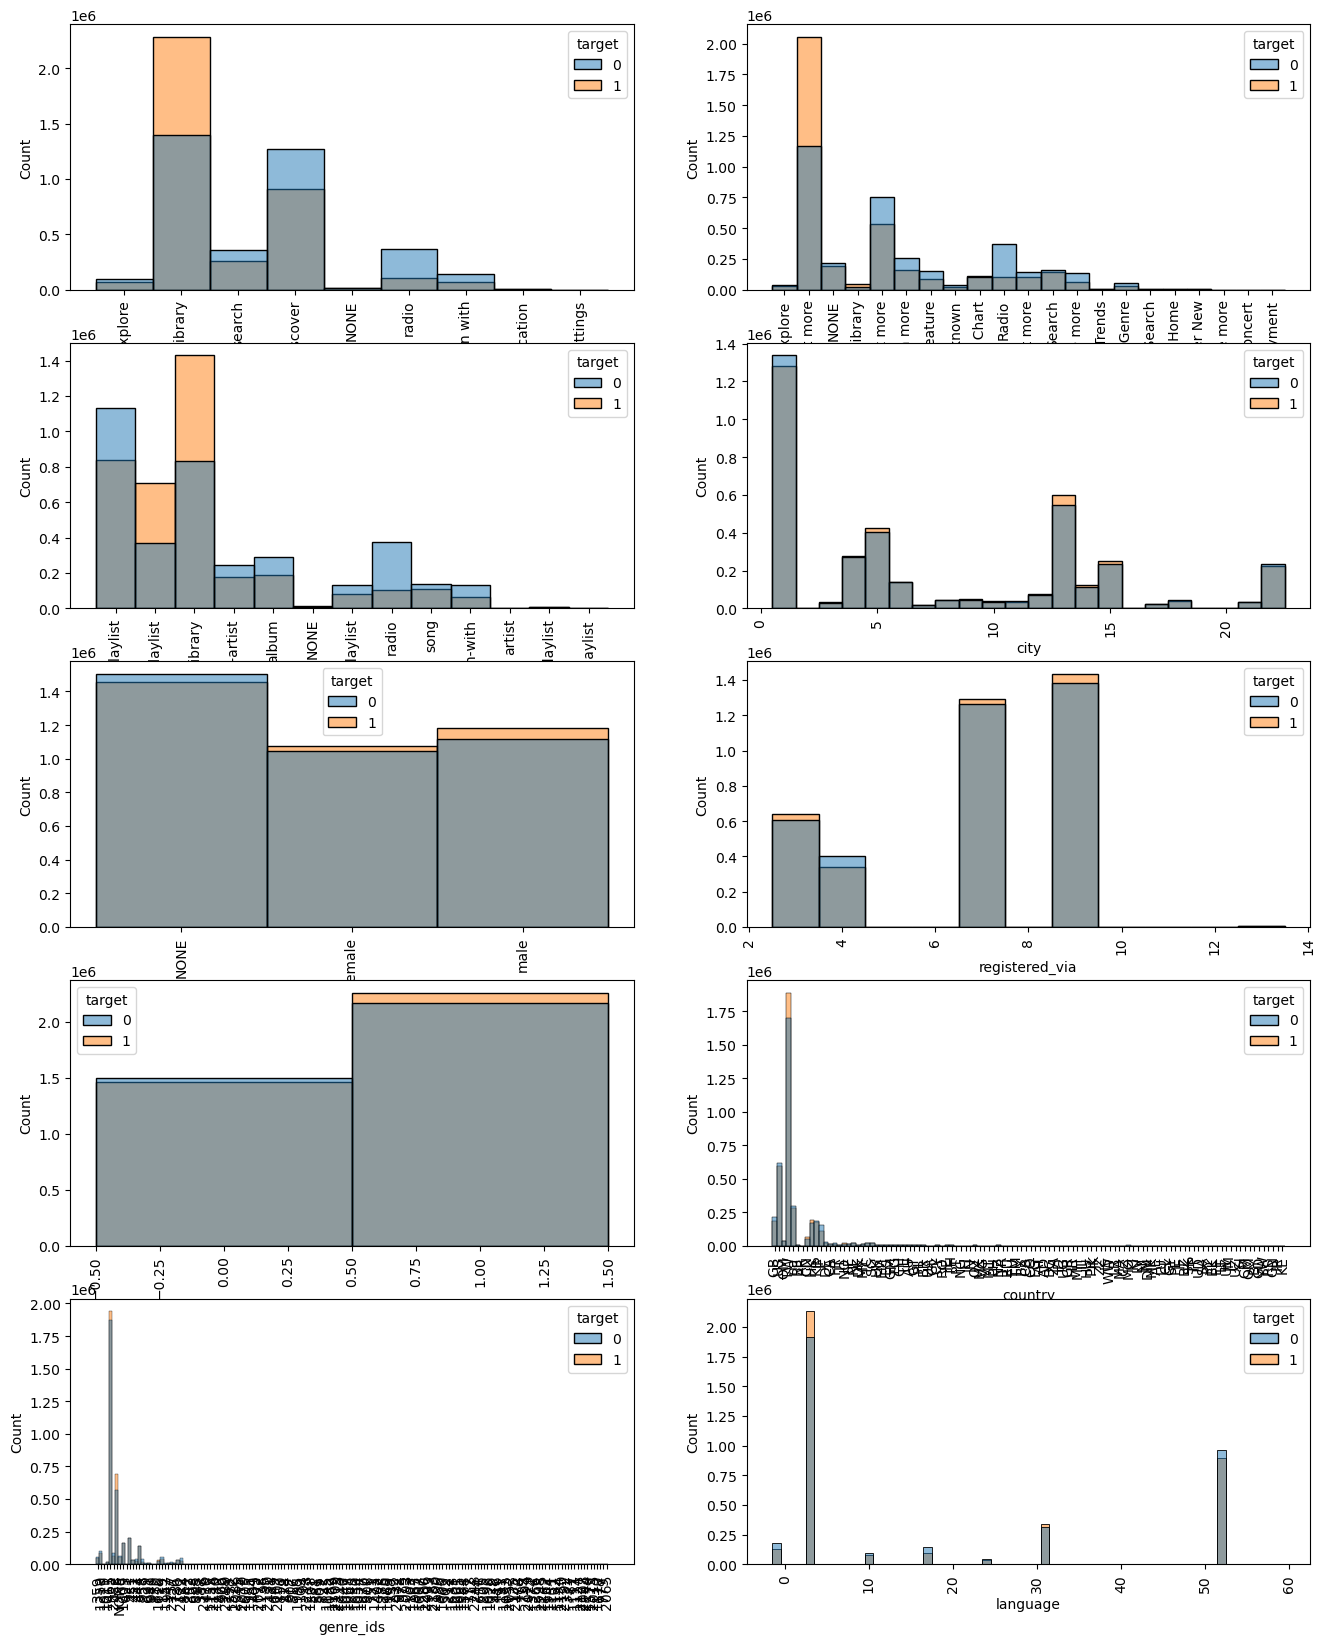

In [60]:
plt.figure(figsize=(16, 20))
flag = 1
for i in range(len(cat)):
    if cat[i] == 'artist_name':
        flag = 0
        continue
    plt.subplot(5, 2, i+flag)
    sns.histplot(data, x=cat[i], hue='target', discrete=True)
    plt.xticks(rotation=90)

plt.show()

Кажется, что каждая категория вносит какую-то существенную информацию о таргете. Сразу мной это не было отмечено, но тут, на графиках, хорошо видно что жанры и способы регистрации содержат большое количество категорий с маленьким количеством объектов. Вероятно, сокращение разнообразия жанров до одного могло внести в это вклад. Как идею, сохраню мысль о том, чтобы добавить категорию с количеством жанров, возможно это помогло бы сохранить часть информации, но сейчас реализовывать не буду, пока это не приоритетная задача.

In [53]:
data.groupby('artist_name')['target'].mean().sort_values(ascending=False)

artist_name
!Conz               1.0
Blind John Davis    1.0
Magneto             1.0
Magnus Bechmann     1.0
MainStreet          1.0
                   ... 
Oboe                0.0
Oblivionized        0.0
Obituary            0.0
ObeyTheKing         0.0
ｗ２ｗＧｏ！Ｇｏ！ぱわふる学園     0.0
Name: target, Length: 39636, dtype: float64

Любопытно, что есть артисты которых переслушивают в 100% случаев и их довольно много.

<Axes: xlabel='target', ylabel='year'>

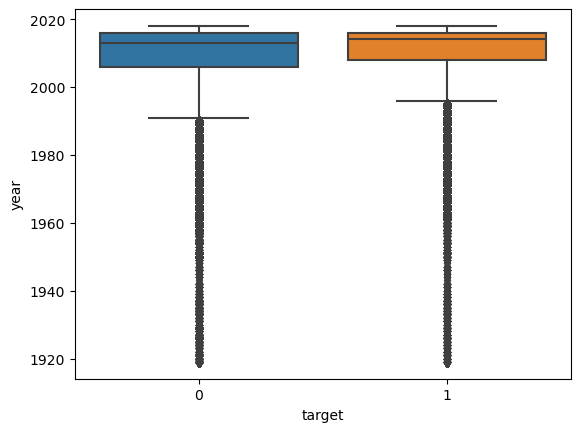

In [90]:
sns.boxplot(data, x='target', y='year')

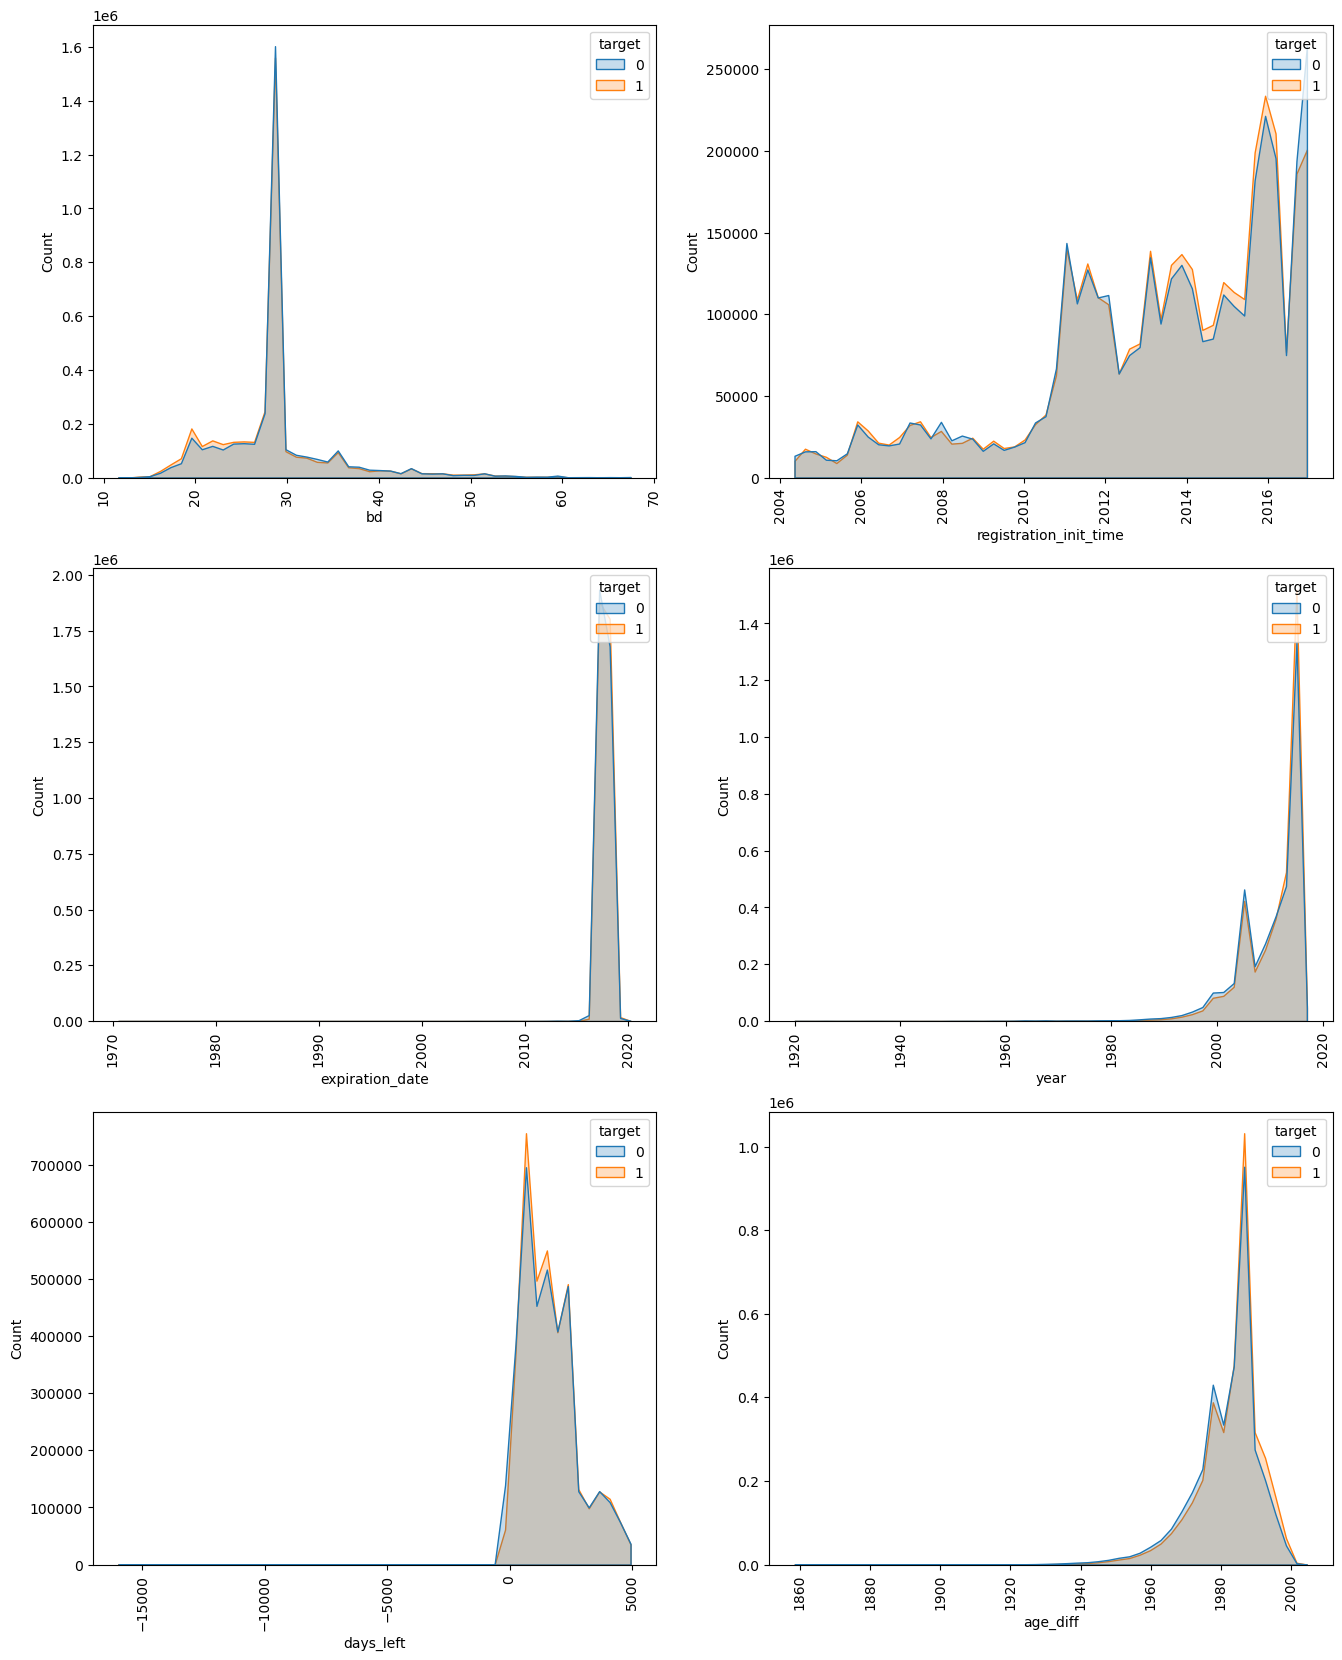

In [91]:
plt.figure(figsize=(16, 20))

for i in range(len(num)):
    plt.subplot(3, 2, i+1)
    sns.histplot(data, x=num[i], hue='target', bins=50, element='poly')
    plt.xticks(rotation=90)

plt.show()

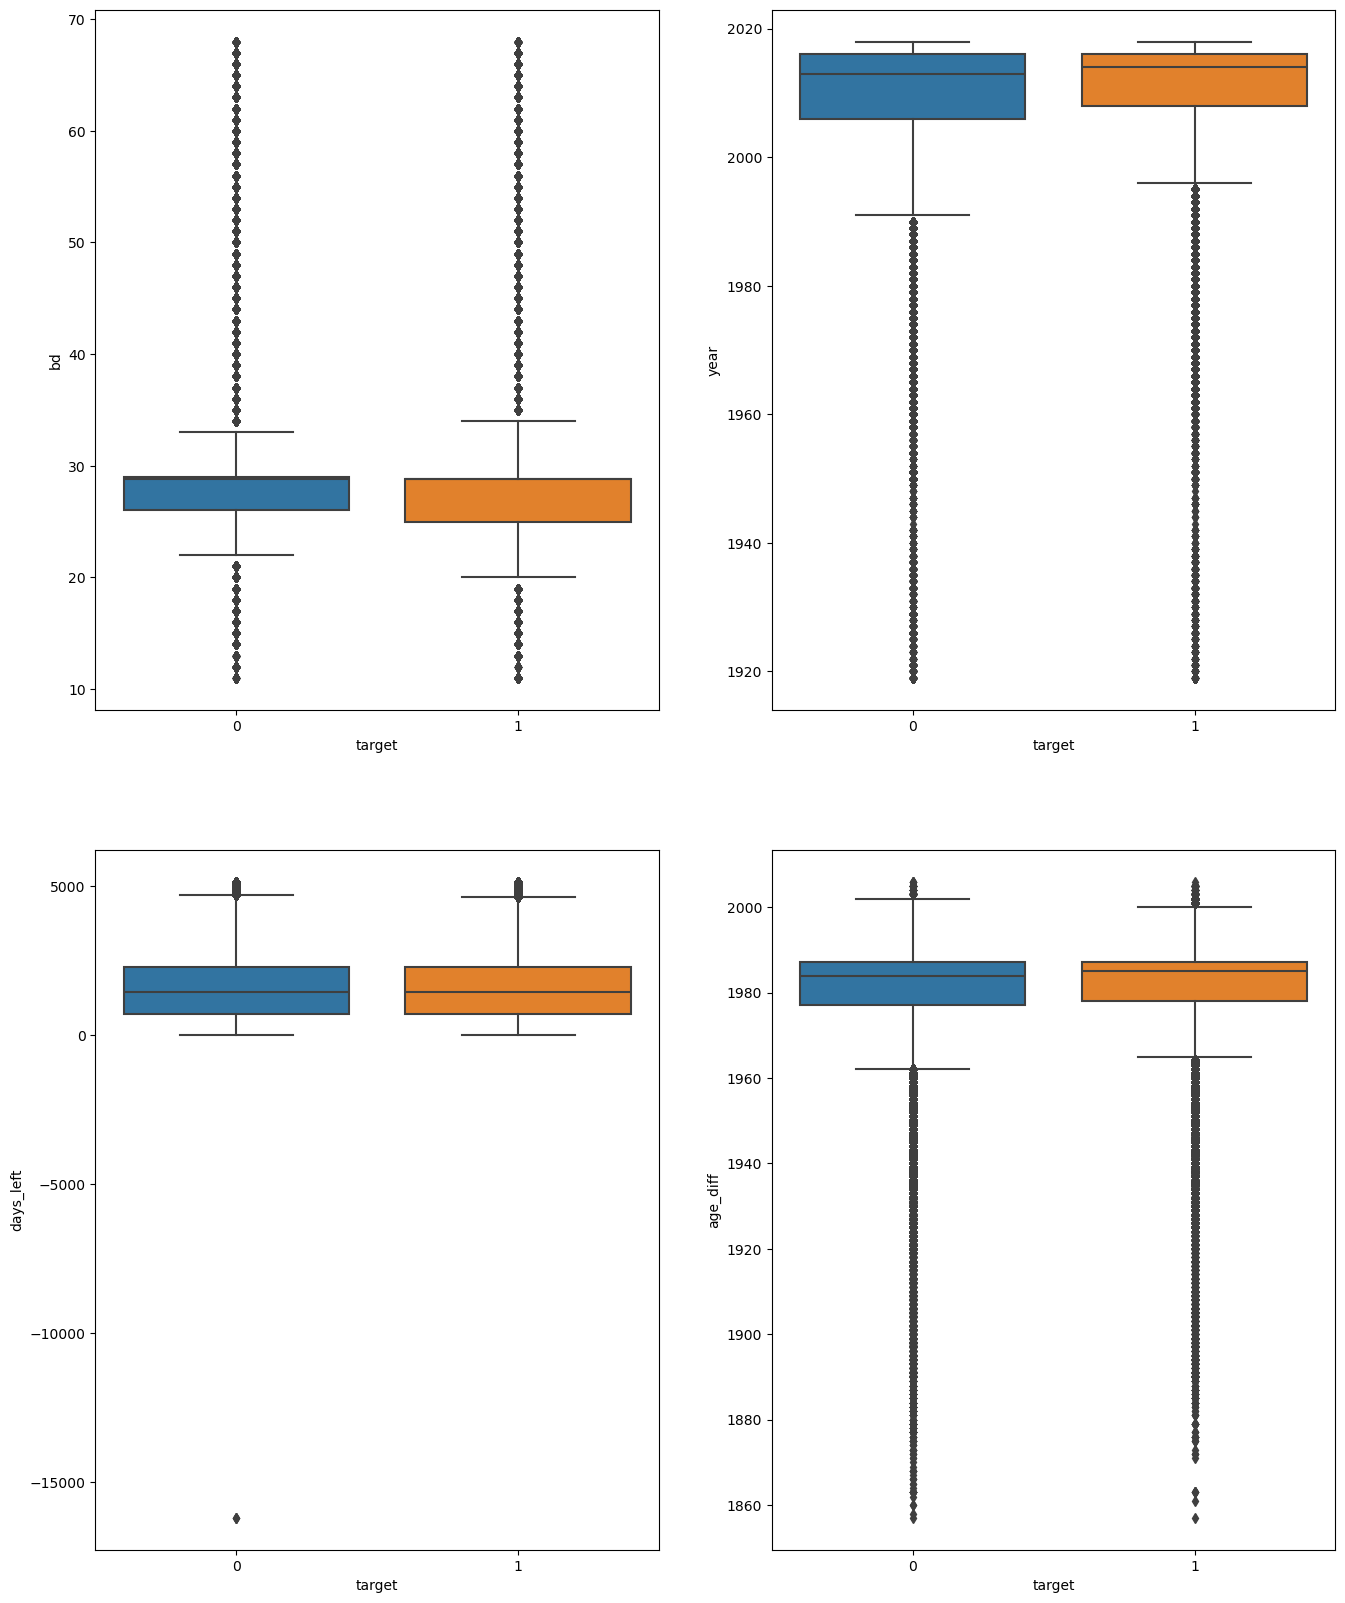

In [93]:
plt.figure(figsize=(16, 20))

flag = 0
for i in range(len(num)):
    if i == 1 or i == 2:
        flag = 2
        continue
    plt.subplot(2, 2, i+1-flag)
    sns.boxplot(data, x='target', y=num[i])

plt.show()

Числовые признаки кажутся менее полезными и в них много ошибочных данных.

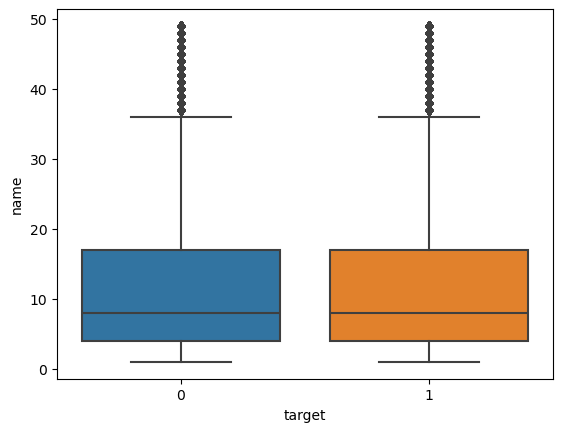

In [72]:
sns.boxplot(data[data.name.apply(len) < 50], x='target', y=data.name.apply(len))
plt.show()

Проверил предположение, что длина названия может быть хорошим признаком. Скорее нет. Увидел, что есть очень длинные названия, возможно будет проблема при обучении. Если да, то заменим название на несколько статистик.

In [75]:
data.target.value_counts()

target
1    3714032
0    3661779
Name: count, dtype: int64

И, на всякий случай, убедимся, что классы сбалансированы

In [71]:
data.to_csv('data/data.csv', index=False)

Сохраняем данные для последующего обучения